# Poor Attendance

This program shows the number of students whose cummulative attendance percentage average is less than the average of all modules.The user or tutor can also view the weeks students' attendance were high when compared to the cummulative average of all modules in the department for this semester. Concurrently, a plot showing the averages of all module attendance per week with :
- reads module attendance and attendance details tables from the database
- merges the module attendance and attendance details into a dataframe
- calculates the weekly attendance percentage of each student for all modules
- formats the poor students dataframe based on a weeks students percentage attendance was above average
- plot a line and scatter plot

## Imports

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import sqlite3

## Functions

### Getting Information from Database

In [12]:
def get_student_module_table(Mod):
    '''
    read database
    input:
        Mod: table name is a a string type
    returning student modules attendance
    
    '''
    conn = sqlite3.connect('C:\\Users\\rolli\\CW\\cop504cwdata\\CWDatabase.db')
    dfMod=pd.read_sql('''select * from %s
                            ''' %(Mod),con=conn).set_index('sessions_id') 
    dfMod.index = dfMod.index.astype("int")
    
    conn.close()
    return dfMod

def get_weeks_from_sessions(Sess):
    '''
    read database 
    input:
        Sess: is module attendance details table name 
    returning only weeks column of module attendance details table
    
    '''
    conn = sqlite3.connect('C:\\Users\\rolli\\CW\\cop504cwdata\\CWDatabase.db')
    dfSess=pd.read_sql('''select week from %s 
                            ''' %(Sess),con=conn)
    conn.close()
    
    return dfSess


### Calculating and Merging Dataframes

In [13]:
def get_weekly_mod_att(dfMod, dfSess):
    '''
    concatenating selected module attendance and details dataframes
    calculating students weekly attendance percentage per module
    output:
        dfMerge: a dataframe of students weekly attendance attendance per module
    '''
    dfModMer=pd.concat([dfMod, dfSess], axis=1)
    dfMerge1=dfModMer.groupby('week').count()
    dfMerge2=dfModMer.groupby('week').sum()
    dfMerge = dfMerge2*100.0/dfMerge1
    dfMerge = dfMerge.transpose()
    dfMerge.index.names=["student_id"]
    dfMerge.columns=[f'Week{int(i + 1)}%' for i in range(dfMerge.shape[1])]
    dfMerge=dfMerge.reset_index()
    dfMerge['Average%'] = dfMerge.iloc[:, 1:].mean(axis=1)
    dfMerge=dfMerge.sort_values("Average%")
    dfMerge=dfMerge.round(0)
    
    return dfMerge

def get_cummulative_average(df_list):
    '''
    concatenating modules
    calculating the cumulative averages of all modules in the semester
    input:
        dflist: contains dataframe of all student attendance per module, list data type
    ouput:
        df: dataframe of students attendance average per semester
    '''
    df = pd.concat(df_list, ignore_index=True)
    df = df.groupby(['student_id'])[[c for c in df.columns if 'Week' in c]].mean()
    df['Average%'] = df.mean(axis=1)
    df = df.reset_index()
    df = df.sort_values(by="Average%")
    
    return df


### Formating Tables

In [14]:
def color_code(value, avg):
    """
    Setting background Colors 
    of table cells 
    value is a cell value. 
    """
    
    if value > avg:
        styler = 'background-color: green'
    else:
        styler = None
    
    return styler

def format_poor_output(dfData, avg):
    """
    applying formatting function to the dataframe.
    """
    subset = [c for c in dfData if 'Week' in c]
    styledOutput=dfData.style.applymap(color_code, subset=subset, avg=avg)\
                              .format(precision=0)
    return styledOutput


### Plotting Dataframes

In [15]:
def plot_attendance(attendance_df_list, modules, df_poor_students, start,end):
    '''
    returns a line and scatter plot of students with poor attenadance average
    input:
        attendance_df_list: student average attendance for each module, list type
        module: module attendance dataframes in a list, list type
        df_poor_students: poor students average dataframe
        start: indicates the starts of the range of students to plot, integer type
        end: indicates the end of the range of students to plot, integer type
    '''
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    for i, df in enumerate(attendance_df_list):
        df = df[df['student_id'].isin(df_poor_students['student_id'])]
        y = df.iloc[:,1:-1].mean().tolist()
        x = range(1, len(y) + 1)
        ax.plot(x, y, label=modules[i])
    df_poor_students = df_poor_students.iloc[start:end]
    for s, df_s in df_poor_students.groupby('student_id'):
        y = df_s.iloc[:, 1:-1].values[0]
        x = range(1, len(y) + 1)
        ax.scatter(x, y, label=s)

    ax.set_xlabel('week')
    ax.set_ylabel('attendance')
    ax.legend(loc='lower left')
    
    return fig, ax

### Extracting Information

In [16]:
def get_att_df_list(modules):
    '''
    returns a list containing concantenated module attendance and details dataframe
    input:modules is a list of module attendance dataframes
    '''
    attendance_df_list = []
    
    for m in modules:
        df_student_module = get_student_module_table(m) # get modules from database
        df_week = get_weeks_from_sessions(f'{m}_Sessions')  # get week column from session metadata table
        df_attendance = get_weekly_mod_att(df_student_module, df_week) # join week from sessions to module dataframe
        attendance_df_list.append(df_attendance)
        
    return attendance_df_list

## Main Code

In [17]:
def poor_students():
    '''
    returns a dataframe of students with poor attendance 
    '''
    modules = ['COA111', 'COA122']
    attendance_df_list = get_att_df_list(modules)
    
    # concatenate modules and calculate cummulative module attendance per student
    df_cummulative = get_cummulative_average(attendance_df_list)

    # include only students with attendance average less than dept attendance average 
    avg = df_cummulative['Average%'].mean()
    print(f'Average of {len(modules)} modules:', avg) # calculate average of all modules
    df_poor_students = df_cummulative[df_cummulative['Average%'] < avg]

    
    # display(format_output(df_poor_students, avg))
    return (df_poor_students,avg)


## Test

In [18]:
# highlight students that have weekly attendace higher than dept average
def highlighted_poor_students():
    '''
    highlights each students weekly module average higher than the department/semester average
    returns dataframe
    '''
    df_poor=poor_students()
    highlight_poor_students=format_poor_output(df_poor[0],df_poor[1]) 
    return highlight_poor_students

In [19]:
# plot attendance
def plot_poor_student_attendance(start,end):
    '''
    returns a plot of students with poor attendance average
    input:
        start, end: select range of students to plot, int type
    '''
    modules=['COA111','COA122']
    fig, ax = plot_attendance(get_att_df_list(modules), modules, poor_students()[0],7,14)
    
    return fig,ax

Average of 2 modules: 72.04769681742043


(<Figure size 800x500 with 1 Axes>, <Axes: xlabel='week', ylabel='attendance'>)

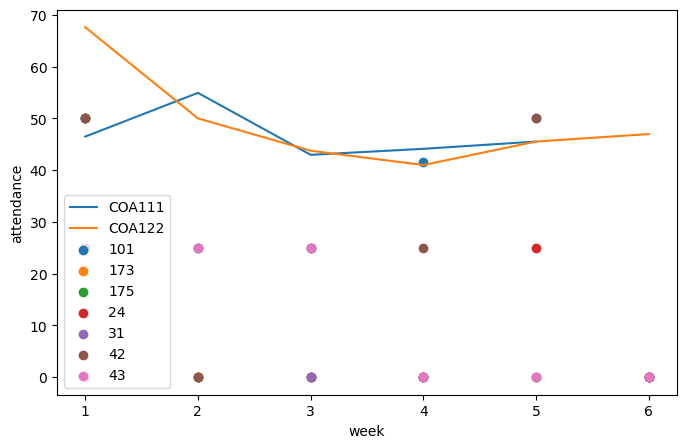

In [20]:
plot_7_10=plot_poor_student_attendance(7,10) 
plot_7_10